In [151]:
from mesa import Agent, Model
from mesa.time import SimultaneousActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector
import numpy as np

In [152]:
class Collector(Agent):
    def __init__(self, unique_id: int, model: Model) -> None:
        super().__init__(unique_id, model)
        self.random.seed(12345)
        self.id = unique_id

    def step(self) -> None:
        pass

In [153]:
class Explorer(Agent):
    RANDOM_SEED = 12345

    def __init__(self, unique_id: int, model: Model) -> None:
        """
        Initializes a new instance of the agent

        Args:
            unique_id (int): Unique identifier of the agent
            model (Model): Model in which the agent is instantiated
        """

        super().__init__(unique_id, model)
        self.random.seed(self.RANDOM_SEED)

        self.visited = set()
        self.direction = "right"

    def move(self) -> None:
        """
        Moves the agent in a random walk, prioritizing unvisited cells.
        """
        neighbors = self.model.grid.get_neighborhood(
                    self.pos, moore=True, include_center=False
                )
        unvisited_neighbors = [
            cell
            for cell in neighbors
            if cell not in self.visited and self.model.grid.is_cell_empty(cell)
        ]

        if unvisited_neighbors:
            new_pos = self.random.choice(unvisited_neighbors)
        else:
            empty_neighbors = [
                cell for cell in neighbors if self.model.grid.is_cell_empty(cell)
            ]
            if empty_neighbors:
                new_pos = self.random.choice(empty_neighbors)
            else:
                return  # No move if no empty cells are available*

        self.model.grid.move_agent(self, new_pos)
        self.visited.add(new_pos)

    def find_food(self) -> None:
        """
        Look for food in the neighboring cells and mark it in the known food layer.
        """
        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=True
        )
        for x, y in neighbors:
            if self.model.food_layer[x][y] > 0:
                self.model.known_food_layer[x][y] = 1

    def find_storage(self) -> None:
        """
        Look for storage in the neighboring cells and mark it in the known storage layer.
        """

        neighbors = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=True
        )
        for x, y in neighbors:
            if self.model.storage_location == (x, y):
                self.model.known_storage_location = (x, y)

    def step(self) -> None:
        """
        Step through the environment.
        """

        self.move()
        self.find_food()

In [154]:
class NomNomModel(Model):
    RANDOM_SEED = 12345

    __slots__ = (
        "schedule",
        "grid",
        "running",
        "food_layer",
        "known_food_layer",
        "storage_location",
        "datacollector",
    )

    def __init__(self, width: int, height: int, num_agents=5, max_food=47) -> None:
        """
        Initializes the model with the given parameters.

        Args:
            width (int): The width of the grid.
            height (int): The height of the grid.
            num_agents (int): The number of agents to be created.
            max_food (int): The maximum amount of food to be created.
        """

        self.random.seed(self.RANDOM_SEED)

        # Data Collector
        self.datacollector = DataCollector(
            {
                "Food": lambda m: np.sum(m.food_layer),
                "Known Food": lambda m: np.sum(m.known_food_layer),
                "Agents": lambda m: m.schedule.get_agent_count(),
                "Warehouse location": lambda m: m.storage_location,
            }
        )

        self.schedule = SimultaneousActivation(self)
        self.grid = SingleGrid(width, height, False)
        self.running = True
        self.total_food_spawned = 0

        # Layers
        self.food_layer = np.zeros((width, height), dtype=np.int8)
        self.known_food_layer = np.zeros((width, height), dtype=np.int8)
        self.known_storage_location = None
        self.num_food = max_food

        # Model Instances
        self.spawn_agents(3, Collector, "collector_")
        self.spawn_agents(2, Explorer, "explorer_")
        self.place_warehouse()

    def spawn_agents(
        self, num_agents: int, agent_class: Agent, prefix: str = ""
    ) -> None:
        """
        Spawns the agents in random places of the grid.

        Args:
            num_agents (int): The number of agents to be created.
            agent_class (Agent): The class of the agent to be created.
        """

        used_positions = set()

        for i, _ in enumerate(range(num_agents)):
            while True:
                x = self.random.randrange(self.grid.width)
                y = self.random.randrange(self.grid.height)

                if (x, y) not in used_positions and self.grid.is_cell_empty((x, y)):
                    agent = agent_class((prefix, i), self)
                    self.grid.place_agent(agent, (x, y))
                    self.schedule.add(agent)

                    used_positions.add((x, y))
                    break

    def spawn_food(self, max_food: int) -> None:
        """
        Spawns the food in random places of the grid between 2 to 5 cells with
        one food item. The interval between the spawns is 5 steps.

        Args:
            max_food (int): The maximum amount of food to be created.
        """

        available_cells = [
            (x, y)
            for x in range(self.grid.width)
            for y in range(self.grid.height)
            if self.grid.is_cell_empty((x, y)) and self.food_layer[x][y] == 0
        ]
        num_food = min(
            self.random.randrange(2, 6),
            max_food - self.total_food_spawned,
            len(available_cells),
        )

        for _ in range(num_food):
            x, y = self.random.choice(available_cells)
            self.food_layer[x][y] = 1
            self.total_food_spawned += 1
            available_cells.remove((x, y))

    def place_warehouse(self) -> None:
        """
        Places the warehouse in the center of the grid.
        """

        while True:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            if self.grid.is_cell_empty((x, y)) and self.food_layer[x][y] == 0:
                self.storage_location = (x, y)
                break

    def step(self) -> None:
        """
        Advances the model by one step. Spawns the food each 5 steps
        """

        self.schedule.step()
        self.datacollector.collect(self)

        # Spawn food each 5 steps
        if self.schedule.steps % 5 == 0:
            self.spawn_food(self.num_food)

# Simulation Parameters

The simulation can be adjusted by changing the parameters in the cell below.

- **num_agents (int)**: The number of agents in the simulation.
- **max_food (int)**: The maximum amount of food that spawns in the simulation.
- **grid_size (int)**: The size of the grid in the simulation (grid_size x grid_size).
- **food_spawn_interval (int)**: The interval at which food spawns in the simulation.
- **min_food_per_spawn (int)**: The minimum amount of food that spawns in the simulation.
- **max_food_per_spawn (int)**: The maximum amount of food that spawns in the simulation.


In [155]:
NUM_AGENTS = 5
MAX_FOOD = 47
GRID_SIZE = 20

FOOD_SPAWN_INTERVAL = 5
MIN_FOOD_PER_SPAWN = 2
MAX_FOOD_PER_SPAWN = 5

In [156]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

def plot_simulation(model: NomNomModel, title: str, figsize=(10, 10), cmap="binary") -> None:
    """
    Plots the simulation grid.

    Args:
        model (NomNomModel): The model to be plotted.
        title (str): The title of the plot.
        figsize (tuple, optional): The size of the figure. Defaults to (10, 10).
        cmap (str, optional): The color map to be used. Defaults to "binary".
    """

    data = model.food_layer.copy()

    plt.figure(figsize=figsize)
    heatmap = plt.imshow(data, cmap=cmap)

    # Warehouse location
    warehouse_x, warehouse_y = model.storage_location
    plt.scatter(warehouse_y, warehouse_x, color="black", marker="s", s=50, label="Warehouse")


    for i in range(len(model.food_layer)):
        for j in range(len(model.food_layer[0])):
            box_color = "white" if model.food_layer[i][j] > 0 else "black"

            plt.text(j, i, model.food_layer[i][j], ha="center", va="center", color=box_color)

    plt.colorbar(heatmap)

    plt.title(title, fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", bbox_to_anchor=(1, 1), fontsize=12)
    plt.xlabel("aisle", fontsize=14)
    plt.ylabel("shelf", fontsize=14)

    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')

    plt.show()

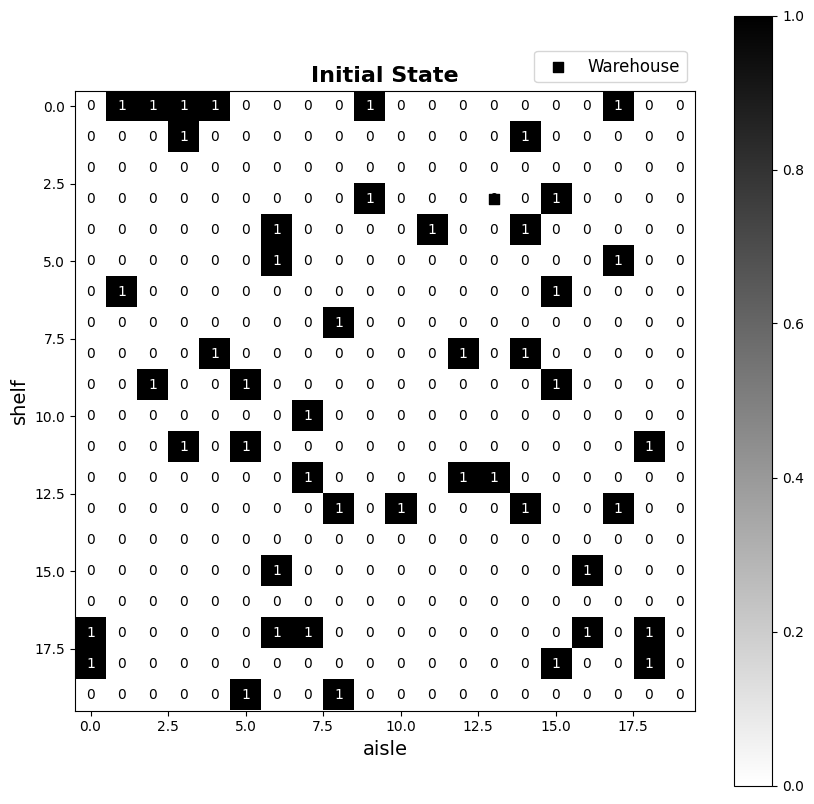

     Food  Known Food  Agents Warehouse location
0       0           0       5            (3, 13)
1       0           0       5            (3, 13)
2       0           0       5            (3, 13)
3       0           0       5            (3, 13)
4       0           0       5            (3, 13)
..    ...         ...     ...                ...
495    47          47       5            (3, 13)
496    47          47       5            (3, 13)
497    47          47       5            (3, 13)
498    47          47       5            (3, 13)
499    47          47       5            (3, 13)

[500 rows x 4 columns]


In [157]:
def run_simulation() -> Model:
    """
    Runs the simulation.
    """

    model = NomNomModel(GRID_SIZE, GRID_SIZE, NUM_AGENTS, MAX_FOOD)

    for _ in range(500):
        model.step()

    plot_simulation(model, "Initial State")
    return model


model = run_simulation()

print(model.datacollector.get_model_vars_dataframe())